In [1]:
%matplotlib notebook

# Redukcija modela za sustav CDplayer.
# Ovaj i druge primjere možete skinuti sa:
# https://www.slicot.org/20-site/126-benchmark-examples-for-model-reduction
# Dalje pretpostavljamo da je datoteka CDplayer.mat u istom direktoriju kad

import math;
import matplotlib.pyplot as plt;
import numpy as np;
import scipy.linalg as sla;
import scipy.io as sio; # Za učitavanje .mat datoteka.
import control.matlab as con;
from matplotlib.animation import FuncAnimation;

con.use_numpy_matrix(flag=False, warn=True)

In [2]:
# Učitamo matrice iz datoteke CDplayer.mat
mat = sio.loadmat( 'CDplayer.mat' );

# Matrica mat['A'] je spremljena kao rijetko popunjena matrica. U "pravom" algoritmu
# ju ne bismo konvertirali u kvadratno polje (dense matricu). Ovdje to radimo samo zato jer 
# nemamo algoritam za rješavanje Lyap. jednadžbe s rijetko popunjenim matricama.
A = np.array( mat['A'].todense() );
B = mat['B'];
C = mat['C'];
D = np.zeros( (C.shape[0], B.shape[1]) );

print( f'Dimenzija matrice A: {A.shape}');
print( f'Dimenzija matrice B: {B.shape}');
print( f'Dimenzija matrice C: {C.shape}');

Dimenzija matrice A: (120, 120)
Dimenzija matrice B: (120, 2)
Dimenzija matrice C: (2, 120)


Ocjena greške ||G-Gr||_hinf <= 2.8582e-01


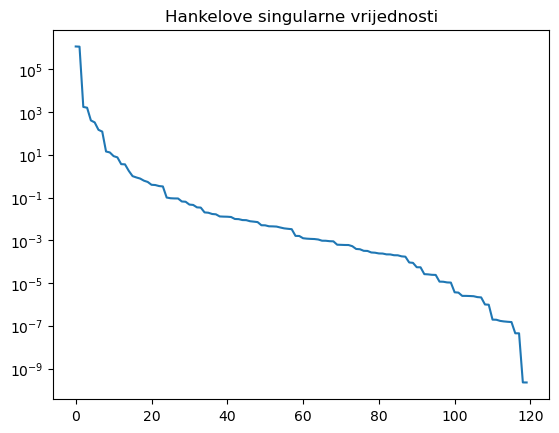

In [3]:
%matplotlib inline

# Algoritam za balansirano rezanje.
# Funkcija prima originalni sustav i dimenziju r na koju treba reducirati matricu.
# Funkcija vraća sustav reduciran na traženu dimenziju.
def balanced_truncation( A, B, C, r=None, plot_svalues=False ):
    n = A.shape[0];

    # Odredimo Gramijane upravljivosti i osmotrivosti.
    # U praksi bi umjesto lyap trebalo koristiti metodu koja je pogodna za velike
    # i rijetko popunjene matrice A -- npr. KPIK, RKSM, LR-ADI i slično!
    P = con.lyap( A, B @ B.T );
    Q = con.lyap( A.T, C.T @ C );

    # Napravi Cholesky faktorizaciju od P, Q.
    LP = sla.cholesky(P, lower=True);
    LQ = sla.cholesky(Q, lower=True);

    # Napravi SVD od LQ'*LP.
    (U, sigma, VT) = sla.svd( LQ.T @ LP );
    V = VT.T;
    
    # Nacrtaj graf singularnih vrijednosti ako treba.
    if( plot_svalues ):
        plt.figure();
        plt.semilogy( sigma );
        plt.title( 'Hankelove singularne vrijednosti' );

    # Odreži na traženom mjestu.
    if( r is not None ):
        Ur = U[:, 0:r]; Vr = V[:, 0:r]; Sr_minus12 = np.diag( 1 / np.sqrt(sigma[0:r]) );
        # Izračunaj ocjenu H-inf norme greške.
        err = 2*np.sum( sigma[r:] );
        print( f'Ocjena greške ||G-Gr||_hinf <= {err:.4e}' );
    else:
        print( 'Treba biti poslan parametar r!' );
        return None;

    T = LP @ (Vr @ Sr_minus12);
    Tinv = LQ @ (Ur @ Sr_minus12);
    
    Ar = Tinv.T @ A @ T; 
    Br = Tinv.T @ B;
    Cr = C @ T;
    
    return (Ar, Br, Cr);


(Ar, Br, Cr) = balanced_truncation( A, B, C, r=40, plot_svalues=True );
Dr = D;

||G-Gr||_hinf = 8.3098e-03


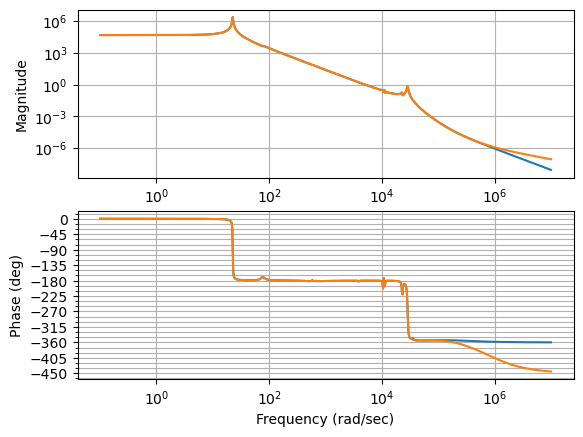

In [4]:
# Originalni i reducirani sustav.
G = con.ss( A, B, C, D );
Gr = con.ss( Ar, Br, Cr, Dr );

# Procijenimo hinf normu razlike G-Gr.
omega = np.logspace( -3, 6, num=1000 );
err_hinf = -1;
for om in omega:
    # Izračunaj ||(G-Gr)(om)||_2.
    err_om = con.evalfr( G-Gr, om );
    err_om_norm = sla.norm( err_om, 2 );
    if( err_hinf == -1 or err_hinf < err_om_norm ):
        err_hinf = err_om_norm;

print( f'||G-Gr||_hinf = {err_hinf:.4e}' );

# Nacrtajmo bode-plot. 
# Funkcija bode u Control Toolboxu radi samo za SISO -> uzmimo preslikavanje prvog inputa u prvi output.
G = con.ss( A, B[:, 0], C[0, :], [0] );
Gr = con.ss( Ar, Br[:, 0], Cr[0, :], [0] );

con.bode( [G, Gr], dB=False );

In [5]:
# Drugi primjer: BEAM.
mat = sio.loadmat( 'beam.mat' );

# Matrica mat['A'] je spremljena kao rijetko popunjena matrica. Sada ju ne konvertiramo
# u punu matricu jer ćemo iskoristiti algoritam za rješavanje Lyap jednadžbi s rijetko 
# popunjenim matricama.
A = mat['A'];
B = mat['B'];
C = mat['C'];
D = np.zeros( (C.shape[0], B.shape[1]) );


D = np.zeros( (C.shape[0], B.shape[1]) );

print( f'Dimenzija matrice A: {A.shape}');
print( f'Dimenzija matrice B: {B.shape}');
print( f'Dimenzija matrice C: {C.shape}');

Dimenzija matrice A: (348, 348)
Dimenzija matrice B: (348, 1)
Dimenzija matrice C: (1, 348)


In [6]:
import scipy.sparse.linalg as ssla;

# Vrlo pojednostavljena implementacija jedne metode za rješavanje Lyap. jednadžbi velikih dimenzija.
def lyap_kpik( A, B, max_iter=100, tol=1e-7 ):
    # Rješava Lyap. jednadžbu A*X + X*At + B*Bt = 0.
    # Vraća X u obliku X = L*Lt, tj. samo faktor L.
    n = A.shape[0]; m = B.shape[1];

    # F-norma matrice A.
    A_normF = ssla.norm( A, ord='fro' );
    
    # Ortonormirana baza prostora na koji projiciramo Lyap. jednadžbu.
    V = np.block( [B, ssla.spsolve( A, B ).reshape( n, m ) ] );
    [V, _] = sla.qr( V, mode='economic' );
    
    for iter in range(0, max_iter):
        # Uzmi zadnjih 2m stupaca od V. Prvih m od njih pomnoži s A, zadnjih m sa A^{-1}.
        # To spremi u Vnew.
        V1 = V[:, -2*m:-m]; V2 = V[:, -m:];
        Vnew = np.block( [A @ V1, ssla.spsolve( A, V2 ).reshape( n, m )] );

        # Ortonormiraj Vnew na V (izračunaj projekciju na orto. komplement).
        Vnew = Vnew - V @ (V.T @ Vnew );
        Vnew = Vnew - V @ (V.T @ Vnew ); # "twice is enough", iako ovo nije Gram-Schmidt!

        # Ortonormiraj međusobno stupce od Vnew.
        [Vnew, _] = sla.qr( Vnew, mode='economic' );
        
        # Proširi V sa Vnew.
        V = np.block( [V, Vnew] );

        # print( f'Ortho(V) = {sla.norm(np.eye(V.shape[1], V.shape[1]) - V.T @ V):.4e}' );
        
        # Projiciraj Lyap. jednadžbu na potprostor V.
        # (pomnoži sa V.T slijeva i sa V zdesna).
        # Ovo se može napraviti PUNO efikasnije.
        Ar = V.T @ (A @ V); Br = V.T @ B;
        # print( f'max(real(eig(Ar))) = {np.max( np.real( sla.eigvals(Ar) ) )}' );

        # Riješi projiciranu Lyap. jednadžbu i nađi korijen od Xr (treba biti Xr >= 0).
        Xr = con.lyap( Ar, Br @ Br.T );
        [Ur, Sr, _] = sla.svd( Xr );
        Lr = Ur @ np.diag( np.sqrt( Sr ) );

        # Aproksimacija faktora rješenja originalne jednadžbe je L = V*Lr.
        L = V @ Lr;
        
        # Izračunaj rezidual i stani ako je mali.
        # Ovo se može napraviti PUNO efikasnije.
        res = sla.norm( (A @ L) @ L.T + L @ (A @ L).T + B @ B.T, ord='fro' );
        print( f'iter={iter}, Vshape={V.shape} -> res={res/A_normF:.4e}' );
        
        if( res < tol * A_normF ):
            break;

    return L;

iter=0, Vshape=(348, 4) -> res=2.9269e+01
iter=1, Vshape=(348, 6) -> res=2.4104e+01
iter=2, Vshape=(348, 8) -> res=6.8454e+00
iter=3, Vshape=(348, 10) -> res=2.5482e+00
iter=4, Vshape=(348, 12) -> res=1.9897e+00
iter=5, Vshape=(348, 14) -> res=5.3486e-01
iter=6, Vshape=(348, 16) -> res=6.7142e-01
iter=7, Vshape=(348, 18) -> res=4.4526e-01
iter=8, Vshape=(348, 20) -> res=7.8116e-01
iter=9, Vshape=(348, 22) -> res=4.8041e-01
iter=10, Vshape=(348, 24) -> res=5.0378e-01
iter=11, Vshape=(348, 26) -> res=2.2479e-01
iter=12, Vshape=(348, 28) -> res=3.7097e-01
iter=13, Vshape=(348, 30) -> res=6.0206e-01
iter=14, Vshape=(348, 32) -> res=1.8290e-01
iter=15, Vshape=(348, 34) -> res=1.8900e-01
iter=16, Vshape=(348, 36) -> res=1.9830e-01
iter=17, Vshape=(348, 38) -> res=1.8650e-01
iter=18, Vshape=(348, 40) -> res=1.4814e-01
iter=19, Vshape=(348, 42) -> res=1.2764e-01
iter=20, Vshape=(348, 44) -> res=1.0090e-01
iter=21, Vshape=(348, 46) -> res=8.8200e-02
iter=22, Vshape=(348, 48) -> res=2.4926e-01
i

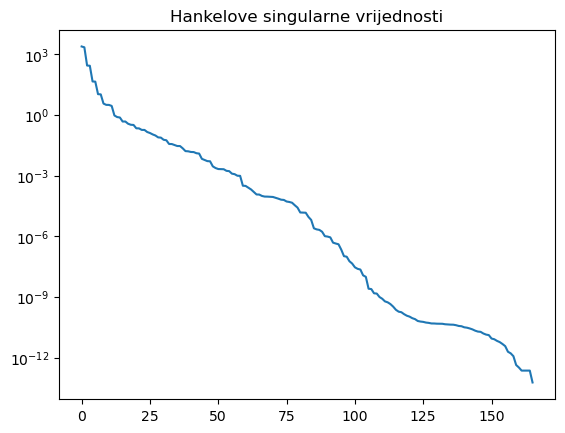

In [7]:
%matplotlib inline

# Funkcija prima originalni sustav i dimenziju r na koju treba reducirati matricu.
# Funkcija vraća sustav reduciran na traženu dimenziju.
def balanced_truncation_sparse( A, B, C, r=None, tol=None, plot_svalues=False ):
    n = A.shape[0];

    # Odredimo Gramijane upravljivosti i osmotrivosti.
    # Sada koristimo metodu KPIK koja je pogodna za velike
    # i rijetko popunjene matrice A.
    # Ona odmah vraća faktore gramijana: P = LP * LP', Q = LQ * LQ'.
    # Uoči: LP, LQ nemaju nužno n stupaca, nego manje!
    LP = lyap_kpik( A, B );
    LQ = lyap_kpik( A.T, C.T );

    rr = min( LP.shape[1], LQ.shape[1] );
    LP = LP[:, :rr]; LQ = LQ[:, :rr];

    # Napravi SVD od LQ'*LP.
    (U, sigma, VT) = sla.svd( LQ.T @ LP );
    V = VT.T;
    
    # Nacrtaj graf singularnih vrijednosti ako treba.
    if( plot_svalues ):
        plt.figure();
        plt.semilogy( sigma );
        plt.title( 'Hankelove singularne vrijednosti' );

    # Odreži na traženom mjestu.
    if( r is not None ):
        Ur = U[:, 0:r]; Vr = V[:, 0:r]; Sr_minus12 = np.diag( 1 / np.sqrt(sigma[0:r]) );
        # Izračunaj ocjenu H-inf norme greške.
        err = 2*np.sum( sigma[r:] );
        print( f'Ocjena greške ||G-Gr||_hinf <= {err:.4e}' );
    else:
        print( 'Treba biti poslan parametar r!' );
        return None;

    T = LP @ (Vr @ Sr_minus12);
    Tinv = LQ @ (Ur @ Sr_minus12);
    
    Ar = Tinv.T @ A @ T; 
    Br = Tinv.T @ B;
    Cr = C @ T;
    
    return (Ar, Br, Cr);


(Ar, Br, Cr) = balanced_truncation_sparse( A, B, C, r=40, plot_svalues=True );
Dr = D;

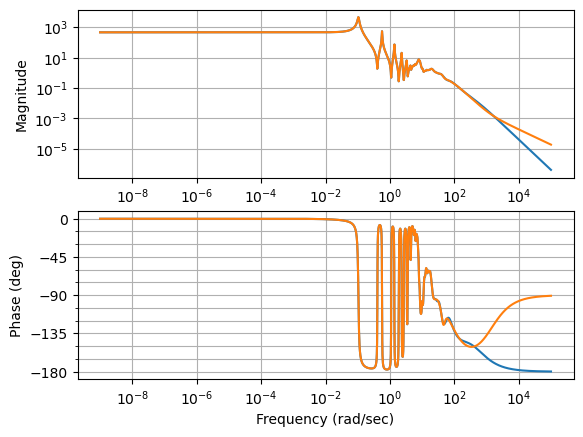

In [8]:
# Originalni i reducirani sustav.
G = con.ss( A.todense(), B, C, D );
Gr = con.ss( Ar, Br, Cr, Dr );

# Procijenimo hinf normu razlike G-Gr.
omega = np.logspace( -9, 5, num=2000 );

# Nacrtajmo bode-plot. 
# Funkcija bode u Control Toolboxu radi samo za SISO -> uzmimo preslikavanje prvog inputa u prvi output.
con.bode( [G, Gr], omega=omega, dB=False );